# Master_Lumos

<h1 style="color: blue;"> Preprocessing for Masks </h1>

In [6]:
import numpy as np
import sys
import os
import glob
from keras.preprocessing import image
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
from scipy import misc
import scipy.io
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.layers import Convolution3D, MaxPooling3D, ZeroPadding3D, UpSampling3D, Deconvolution3D, Cropping3D
from keras.models import Sequential, Model
import time
import re

In [7]:
#All images must be .jpg and image index assumed to start at 1
#If output paths do not exist they will be created
PATH_DATASET_PREPROCESSING_MASKS_NOT_GLAUCOMA = "/Users/karimabedrabbo/Desktop/work/cropped_not_glaucoma/"
PATH_DATASET_PREPROCESSING_MASKS_GLAUCOMA = "/Volumes/U/stuff/"

CAFFE_ROOT = '/Users/karimabedrabbo/caffe/'

OUTPUT_PATH_PREPROCESSING_MASKS_VESSELS = "/Users/karimabedrabbo/Desktop/0C2G16/"
OUTPUT_PATH_PREDICTIONS_MASKS_VESSELS = "/Users/karimabedrabbo/Desktop/big_dataset_gamma/"

PATH_TO_PROTOTEXTS_VESSELS = "/Users/karimabedrabbo/caffe/DRIU/DRIU_DRIONS/"
PATH_TO_CAFFE_MODELS_VESSELS = "/Users/karimabedrabbo/caffe/DRIU/DRIU_DRIONS/"

MODEL_VESSELS = "DRIU_DRIVE.caffemodel"
PROTOTEXT_VESSELS = "deploy_DRIVE.prototxt"


OUTPUT_PATH_PREPROCESSING_MASKS_DISC = "/Users/karimabedrabbo/Desktop/testing_preprocessing/blood_vessels/preprocessed_images/"
OUTPUT_PATH_PREDICTIONS_MASKS_DISC = "/Users/karimabedrabbo/Desktop/Testing_Preprocessing/Results/"

PATH_TO_PROTOTEXTS_DISC = "/Users/karimabedrabbo/Desktop/testing_preprocessing/blood_vessels/prototexts"
PATH_TO_CAFFE_MODELS_DISC = "/Users/karimabedrabbo/Desktop/testing_preprocessing/blood_vessels/caffe_models"

MODEL_DISC = "DRIU_DRIVE.caffemodel"
PROTOTEXT_DISC = "deploy_DRIVE.prototxt"


OUTPUT_PATH_PREPROCESSING_MASKS_CUP = "/Users/karimabedrabbo/Desktop/testing_preprocessing/blood_vessels/preprocessed_images/"
OUTPUT_PATH_PREDICTIONS_MASKS_CUP = "/Users/karimabedrabbo/Desktop/Testing_Preprocessing/Results/"

PATH_TO_PROTOTEXTS_CUP = "/Users/karimabedrabbo/Desktop/testing_preprocessing/blood_vessels/prototexts"
PATH_TO_CAFFE_MODELS_CUP = "/Users/karimabedrabbo/Desktop/testing_preprocessing/blood_vessels/caffe_models"

MODEL_CUP = "DRIU_DRIVE.caffemodel"
PROTOTEXT_CUP = "deploy_DRIVE.prototxt"

<h3 style="color: red;"> Blood Vessels </h3>

In [8]:
def preprocess_vessels_masks(glaucoma, clip_limit_start, clip_limit_end, clip_limit_step, grid_size_start, grid_size_end, grid_size_step, data_root, save_root):
    
    if not os.path.exists(save_root):
        os.makedirs(save_root)
        
    if glaucoma:
        glaucoma_binary = 1
    else:
        glaucoma_binary = 0
    
    images_list = glob.glob1(data_root,"*.jpg")
    num_images = len(images_list)
        
    for clip_limit in range (clip_limit_start, clip_limit_end + clip_limit_step, clip_limit_step):
        for grid_size in range(grid_size_start,grid_size_end + grid_size_step, grid_size_step):
            indexed_folder = str(glaucoma_binary) + "C" + str(clip_limit) + "G" + str(grid_size)
            
            output_image_folder_path = save_root + indexed_folder + "/"
            if not os.path.exists(output_image_folder_path):
                    os.makedirs(output_image_folder_path)
            
            text_file = open(output_image_folder_path + indexed_folder + ".txt", "w")
            for image_number in range(1,num_images + 1):
                img = image.load_img(data_root + str(image_number) + ".jpg")
                arr = np.array(img)
                arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
                arr = np.stack((arr,)*3, axis=-1)
                lab= cv2.cvtColor(arr, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size,grid_size))
                cl = clahe.apply(l)
                limg = cv2.merge((cl,a,b))
                arr = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
                final = misc.toimage(arr)
                output_image_path = output_image_folder_path + str(image_number) + ".jpg"
                final.save(output_image_path)
                text_file.write("%s.jpg\n" % str(image_number))

In [9]:
#list clip_grid in format ["CnumGnum"] i.e. ["C2G24]
def preprocess_vessels_list(glaucoma, clip_grid, save_root, data_root):
    for param in clip_grid:
        clip_size = int(param[param.find("C")+1:param.find("G")])
        grid_size = int(param[param.find("G")+1:])
        preprocess_vessels_masks(glaucoma, clip_limit_start=clip_size, clip_limit_end=clip_size, clip_limit_step=1, 
                                 grid_size_start=grid_size, grid_size_end=grid_size, grid_size_step=1, save_root=save_root, data_root=data_root)

In [10]:
preprocess_vessels_list(glaucoma=True, clip_grid = ["C2G16"], save_root=OUTPUT_PATH_PREPROCESSING_MASKS_VESSELS, data_root=PATH_DATASET_PREPROCESSING_MASKS_GLAUCOMA)
preprocess_vessels_list(glaucoma=False, clip_grid = ["C2G16"], save_root=OUTPUT_PATH_PREPROCESSING_MASKS_VESSELS, data_root=PATH_DATASET_PREPROCESSING_MASKS_NOT_GLAUCOMA)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


<h1 style="color: blue;"> Predicting Masks </h1>

<h3 style="color: red;"> Blood Vessels </h3>

In [ ]:
sys.path.insert(0, CAFFE_ROOT + 'python/')
import caffe

In [1]:
def predict_vessels_masks(indexed_folder, data_root, save_root, prototext_path, model_path):
# Choose between 'DRIVE', 'STARE', 'DRIONS', and 'RIMONE'    
    use_gpu = 0;
    gpu_id = 0;

    
    
    if not os.path.exists(save_root):
        os.makedirs(save_root)

    output_image_folder_path = data_root + indexed_folder + "/"
    
    with open(output_image_folder_path + indexed_folder + '.txt') as f:
        imnames = f.readlines()
        
    test_list = [output_image_folder_path+x.strip() for x in imnames]
    
    if use_gpu:
        caffe.set_mode_gpu()
        caffe.set_device(gpu_id)

    net = caffe.Net(prototext_path, model_path, caffe.TEST)

    for idx in range(0,len(test_lst)):
        print("Prediction on " + imnames[idx][:-1])
        
        #Read and preprocess data
        im = Image.open(test_lst[idx])
        in_ = np.array(im, dtype=np.float32)
        in_ = in_[:,:,::-1] #BGR
        in_ -= np.array((171.0773,98.4333,58.8811)) #Mean substraction
        in_ = in_.transpose((2,0,1))
        
        #Reshape data layer
        net.blobs['data'].reshape(1, *in_.shape)
        net.blobs['data'].data[...] = in_
        
        #Score the model
        net.forward()
        fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]
        
        #Save the results
        scipy.misc.imsave(save_root+imnames[idx][:-1], fuse)

In [2]:
#just indexed_folders with preprocessed images, no other files
def predict_directory(data_root, save_root, prototext_path, model_path):
    folders_list = glob.glob1(data_root, "*")
    for indexed_folder in folders_list:
        predict_vessels_masks(indexed_folder, data_root, save_root, prototext_path, model_path)
    

In [ ]:
predict_directory(data_root = OUTPUT_PATH_PREPROCESSING_MASKS_VESSELS, save_root = OUTPUT_PATH_PREDICTIONS_MASKS_VESSELS,
                  prototext_path = PATH_TO_PROTOTEXTS_VESSELS, model_path = PATH_TO_CAFFE_MODELS_VESSELS)


<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> Visualization of Masks </h1>


<h3 style="color: red;"> Blood Vessels </h3>

In [43]:
def view_masks(glaucoma, image_num, data_root_original, data_root_masks):
    
    if glaucoma:
        folder_group = ["1C2G16"]
    else:
        folder_group = ["0C2G16"]
        
    #image_num_group = [(str(image_num) + "_" + folder_group[0] + ".jpg"), (str(image_num) + "_" + folder_group[1] + ".jpg"), (str(image_num) + "_" + folder_group[2] + ".jpg")]

    fig = plt.figure(figsize=(30, 30))  # width, height in inches
    
    for i in range(0,2):
        sub = fig.add_subplot(1, 2, i+1)
        if i==0:
            im = image.load_img(data_root_original + str(image_num) + ".jpg")
            sub.imshow(im, interpolation='nearest')
            plt.title(image_num)
        else:
            im = image.load_img(data_root_masks + folder_group[0] + "/" + str(image_num) + ".jpg")
            sub.imshow(im, interpolation='nearest')
        plt.axis('off')

In [36]:
def view_all_masks(glaucoma, data_root_original, data_root_masks,):
    num_imgs = len(glob.glob1(data_root_original,"*.jpg"))
    for i in range(1,num_imgs):
        view_masks(glaucoma, i, data_root_original, data_root_masks)
    
    

In [37]:
def view_range_masks(glaucoma, start, end, data_root_original, data_root_masks):
    for i in range(start,end+1):
        view_masks(glaucoma, i, data_root_original, data_root_masks)
    

In [38]:
def view_list_masks(glaucoma, numbers, data_root_original, data_root_masks):
    for i in numbers:
        view_masks(glaucoma, i, data_root_original, data_root_masks)

In [ ]:
"""
view_range_masks(glaucoma=False, start=3, end=5, data_root_original=PATH_DATASET_PREPROCESSING_MASKS_NOT_GLAUCOMA, 
                 data_root_masks=OUTPUT_PATH_PREDICTIONS_MASKS_VESSELS)
view_range_masks(glaucoma=True, start=3, end=5, data_root_original=PATH_DATASET_PREPROCESSING_MASKS_GLAUCOMA, 
                 data_root_masks=OUTPUT_PATH_PREDICTIONS_MASKS_VESSELS)
"""

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> Automated Choosing Best Masks </h1>

<h3 style="color: red;"> Blood Vessels </h3>

In [3]:
for i in range(1,1304):
    print(str(i) + ".jpg")

1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
30.jpg
31.jpg
32.jpg
33.jpg
34.jpg
35.jpg
36.jpg
37.jpg
38.jpg
39.jpg
40.jpg
41.jpg
42.jpg
43.jpg
44.jpg
45.jpg
46.jpg
47.jpg
48.jpg
49.jpg
50.jpg
51.jpg
52.jpg
53.jpg
54.jpg
55.jpg
56.jpg
57.jpg
58.jpg
59.jpg
60.jpg
61.jpg
62.jpg
63.jpg
64.jpg
65.jpg
66.jpg
67.jpg
68.jpg
69.jpg
70.jpg
71.jpg
72.jpg
73.jpg
74.jpg
75.jpg
76.jpg
77.jpg
78.jpg
79.jpg
80.jpg
81.jpg
82.jpg
83.jpg
84.jpg
85.jpg
86.jpg
87.jpg
88.jpg
89.jpg
90.jpg
91.jpg
92.jpg
93.jpg
94.jpg
95.jpg
96.jpg
97.jpg
98.jpg
99.jpg
100.jpg
101.jpg
102.jpg
103.jpg
104.jpg
105.jpg
106.jpg
107.jpg
108.jpg
109.jpg
110.jpg
111.jpg
112.jpg
113.jpg
114.jpg
115.jpg
116.jpg
117.jpg
118.jpg
119.jpg
120.jpg
121.jpg
122.jpg
123.jpg
124.jpg
125.jpg
126.jpg
127.jpg
128.jpg
129.jpg
130.jpg
131.jpg
132.jpg
133.jpg
134.jpg
135.jpg
136.jpg
137.jpg
138.jpg
139.

IOError: [Errno 2] No such file or directory: '/Users/karimabedrabbo/caffe/DRIU/results/0C2G16/165.jpg'

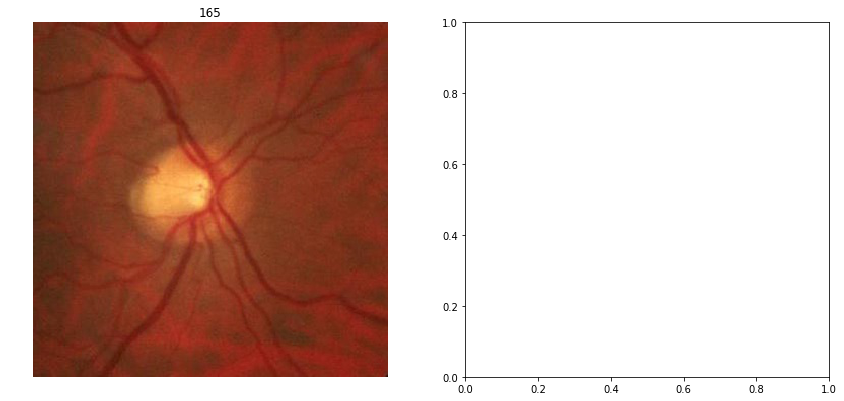

In [39]:
for i in range(165,176):
    view_masks(glaucoma=False, image_num=i, data_root_original=PATH_DATASET_PREPROCESSING_MASKS_NOT_GLAUCOMA, 
                 data_root_masks=OUTPUT_PATH_PREDICTIONS_MASKS_VESSELS)

In [4]:
images_max = []
for i in range(1,263):
    im = image.load_img("/Users/karimabedrabbo/Desktop/omp_big_dataset/glaucoma/"+str(i)+".jpg")
    arr = np.array(im)
    hsv = cv2.cvtColor(arr, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    hist = cv2.calcHist([v],[0],None,[255],[0,255])
    flat_hist = [value for sublist in hist for value in sublist]
    print("For " + str(i) + " Brightness is: " + str(flat_hist.index(max(flat_hist))))

For 1 Brightness is: 186
For 2 Brightness is: 199
For 3 Brightness is: 141
For 4 Brightness is: 167
For 5 Brightness is: 254
For 6 Brightness is: 254
For 7 Brightness is: 254
For 8 Brightness is: 161
For 9 Brightness is: 169
For 10 Brightness is: 172
For 11 Brightness is: 141
For 12 Brightness is: 254
For 13 Brightness is: 254
For 14 Brightness is: 162
For 15 Brightness is: 254
For 16 Brightness is: 254
For 17 Brightness is: 254
For 18 Brightness is: 170
For 19 Brightness is: 174
For 20 Brightness is: 194
For 21 Brightness is: 254
For 22 Brightness is: 208
For 23 Brightness is: 254
For 24 Brightness is: 254
For 25 Brightness is: 215
For 26 Brightness is: 254
For 27 Brightness is: 196
For 28 Brightness is: 254
For 29 Brightness is: 254
For 30 Brightness is: 254
For 31 Brightness is: 229
For 32 Brightness is: 254
For 33 Brightness is: 254
For 34 Brightness is: 254
For 35 Brightness is: 106
For 36 Brightness is: 108
For 37 Brightness is: 135
For 38 Brightness is: 254
For 39 Brightness is:

In [ ]:
def choose_best_vessels_masks(glaucoma, data_root_original, data_root_masks, save_root)
    images_list = glob.glob1(data_root,"*.jpg")
    for i, image in enumerate(images_list):
        

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> Predictions of Masks </h1>

<h3 style="color: red;"> Blood Vessels </h3>

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> CNN for Masks </h1>

<h3 style="color: red;"> Blood Vessels </h3>

In [12]:
K.set_image_dim_ordering('tf')

In [23]:
def get_unet(images = 1, img_rows=256, img_cols=256, channels=3):
    inputs = Input(shape=(images, img_rows, img_cols, channels))
    
    flatten = Flatten()(inputs)
    
    reshape = Reshape(images, (flatten)
    
    
    conv1 = Convolution3D(32, (1, 3, 3), activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution3D(32, (1, 3, 3), activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)

    conv2 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)

    conv3 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)

    conv4 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)

    conv5 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling3D(size=(1, 2, 2))(conv5), conv4], mode='concat', concat_axis=-1)
    conv6 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling3D(size=(1, 2, 2))(conv6), conv3], mode='concat', concat_axis=-1)
    conv7 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling3D(size=(1, 2, 2))(conv7), conv2], mode='concat', concat_axis=-1)
    conv8 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution3D(64, (1, 3, 3), activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling3D(size=(1, 2, 2))(conv8), conv1], mode='concat', concat_axis=-1)
    conv9 = Convolution3D(32, (1, 3, 3), activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution3D(32, (1, 3, 3), activation='relu', border_mode='same')(conv9)

    conv10 = Convolution3D(1, (1, 1, 1), activation='sigmoid', border_mode='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    model.summary()

    return model

In [24]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for image_filename in os.listdir(folder):
        img_file = cv2.imread(folder + '/' + image_filename)
        if img_file is not None:
            if not image_filename.startswith('NoGlauc'):
                label = 0
            else:
                label = 1
            img_file = scipy.misc.imresize(arr=img_file, size=(256, 256, 3))
            img_file = img_file/255
            img_arr = np.asarray(img_file)
            img_arr = np.expand_dims(img_arr, axis=0)
            X.append(img_arr)
            y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [25]:
def batch_iter(data, labels, batch_size, shuffle=True):
    num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1

    def data_generator():
        data_size = len(data)
        while True:
            # Shuffle the data at each epoch
            if shuffle:
                shuffle_indices = np.random.permutation(np.arange(data_size))
                shuffled_data = data[shuffle_indices]
                shuffled_labels = labels[shuffle_indices]
            else:
                shuffled_data = data
                shuffled_labels = labels

            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                X, y = shuffled_data[start_index: end_index], shuffled_labels[start_index: end_index]
                yield X, y

    return num_batches_per_epoch, data_generator()

In [27]:
data_root = OUTPUT_PATH_PREDICTIONS_MASKS_CUP
images_list = glob.glob1(data_root,"*.jpg")
num_images = len(images_list)



model_cup = get_unet_3D()
X_train, y_train = get_data('normalized_data_renamed/training/')
X_test, y_test = get_data('normalized_data_renamed/testing/')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (1, 3, 3), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (1, 3, 3), padding="same", activation="relu")`
  """
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (1, 3, 3), padding="same", activation="relu")`
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (1, 3, 3), padding="same", activation="relu")`
  # Remove the CWD from 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1, 256, 256,  0                                            
__________________________________________________________________________________________________
conv3d_47 (Conv3D)              (None, 1, 256, 256,  896         input_7[0][0]                    
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 1, 256, 256,  0           conv3d_47[0][0]                  
__________________________________________________________________________________________________
conv3d_48 (Conv3D)              (None, 1, 256, 256,  9248        dropout_23[0][0]                 
__________________________________________________________________________________________________
max_poolin

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:42: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (1, 3, 3), padding="same", activation="relu")`
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (1, 3, 3), padding="same", activation="relu")`
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")`
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/sit

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> Deep-Neural-Style for Normalization </h1>

<h3 style="color: red;"> Blood Vessels </h3>

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> CNN for Glaucoma </h1>

<h3 style="color: red;"> Blood Vessels </h3>

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>


<h1 style="color: blue;"> Segmentation for Lens (future) </h1>

<h3 style="color: red;"> Blood Vessels </h3>

<h3 style="color: red;"> Disc </h3>


<h3 style="color: red;"> Cup </h3>
